In [1]:
# Goal: Predict the next day closing price of Apple stock using Long Short Term Memory (LSTM) with the closing price data from the past year.

In [2]:
# Import libraries
import math
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import warnings
plt.style.use('fivethirtyeight')
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [3]:
# Get Apple Stock Quote from past year
df = web.DataReader('AAPL', data_source='yahoo', start='2020-03-13', end='2021-03-13')

In [4]:
# Create new df with only close column
data = df.filter(['Close'])
# Convert df to numpy array
dataset = data.values
# Get number of rows to train model on
training_data_len = math.ceil( len(dataset) * .8)

In [5]:
# Scale data
scalar = MinMaxScaler(feature_range=(0,1))
scaled_data = scalar.fit_transform(dataset)

In [6]:
# Create scaled training dataset
train_data = scaled_data[0:training_data_len, :]
# Split data into x_train and y_train datasets
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

In [7]:
# Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [8]:
# Reshape x_train
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_train.shape

(142, 60, 1)

In [9]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
# Predict next closing value
model.add(Dense(units=1))

In [10]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# Train the model
model.fit(x_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
5/5 [==============================] - 5s 65ms/step - loss: 0.3986
Epoch 2/100
5/5 [==============================] - 0s 70ms/step - loss: 0.0643
Epoch 3/100
5/5 [==============================] - 0s 66ms/step - loss: 0.0486
Epoch 4/100
5/5 [==============================] - 0s 66ms/step - loss: 0.0268
Epoch 5/100
5/5 [==============================] - 0s 67ms/step - loss: 0.0244
Epoch 6/100
5/5 [==============================] - 0s 65ms/step - loss: 0.0149
Epoch 7/100
5/5 [==============================] - 0s 68ms/step - loss: 0.0166
Epoch 8/100
5/5 [==============================] - 0s 69ms/step - loss: 0.0121
Epoch 9/100
5/5 [==============================] - 0s 66ms/step - loss: 0.0115
Epoch 10/100
5/5 [==============================] - 0s 66ms/step - loss: 0.0126
Epoch 11/100
5/5 [==============================] - 0s 74ms/step - loss: 0.0089
Epoch 12/100
5/5 [==============================] - 0s 66ms/step - loss: 0.0109
Epoch 13/100
5/5 [==============================]

In [12]:
# Create testing dataset
test_data = scaled_data[training_data_len - 60: , :]
# Create datasets x_test and y_test
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [13]:
# Convert data to a numpy array
x_test = np.array(x_test)

In [14]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [15]:
# Get models predicted price values
predictions = model.predict(x_test)
predictions = scalar.inverse_transform(predictions)

In [16]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

7.372752071376083

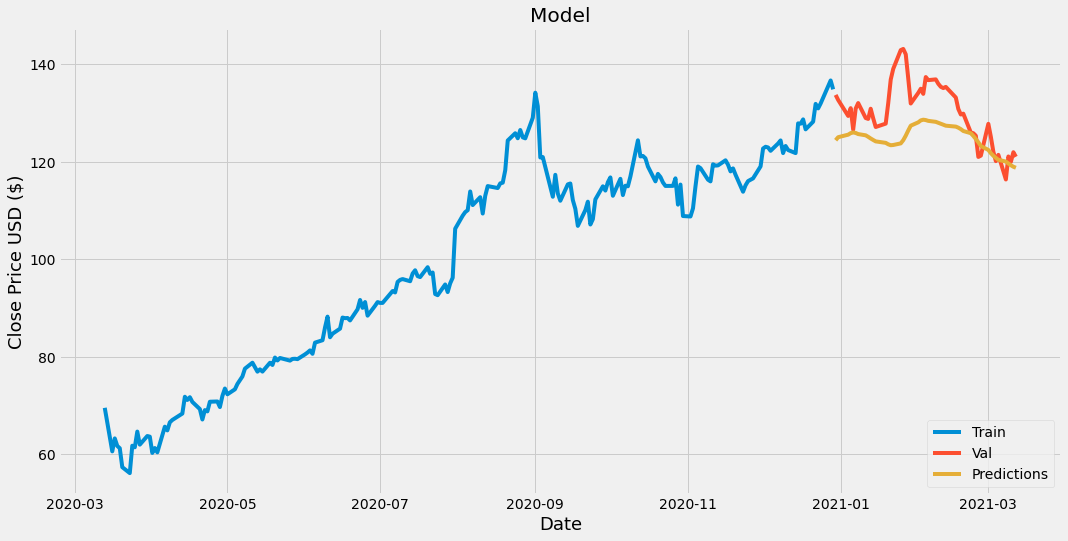

In [17]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','Predictions'], loc = 'lower right')
plt.show()

In [18]:
# Get quote again to predict next days price
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2020-03-13', end='2021-03-13')
new_df = apple_quote.filter(['Close'])
last_60_days = new_df[-60:].values

# Scale data to be values between 0 and 1
last_60_days_scaled = scalar.transform(last_60_days)

# Make new X_test dataset
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get predicted scaled price
pred_price = model.predict(X_test)

# Undo scaling
pred_price = scalar.inverse_transform(pred_price)

# Print next day predicted price
print(pred_price)

[[118.65749]]
